# Section 5: Lensing Maps

As part of the ACT data release 4 (DR4) we include lensing maps which are constructed using data from Seasons 2014-2015 and that are publicly available on LAMBDA.  These maps are discussed more in depth in [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf) but this section will help users access and examine the maps as well as go through a simple cross correlation example. 

The two seasons of 98 GHz and 150 GHz maps are coadded to produce the input maps for the lensing estimator.  Once processed the resulting maps cover 2100 square degrees on the sky and are signal dominated on large scales.  They also overlap with a number of optical surveys which enables them to be used for cross correlations such as the one performed with BOSS CMASS galaxies in [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf).  The release also includes lensing maps with the thermal Sunyaev-Zel'dovich signal removed, which is done using a new procedure that has minimal effect on the lensing signal-to-noise ratio.

These maps can be accessed and used with the same Pixell commands implemented in previous notebooks meaning users can trim them and study small patches as needed. The available files are documented in table 3.

We ask that when using these data products you reference the original work done in [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf).

Notebook Info | Value
---|---
Dependencies | `numpy`, `scipy`, `healpy`, `matplotlib`, `pixell`
Data products | "act_planck_dr4.01_s14s15_D56_lensing_kappa_baseline.fits"
| "galaxy_DR12v5_CMASSLOWZTOT_South.fits"
|"act_dr4.01_s14s15_D56_lensing_mask.fits"
Memory usage | Medium (~ a few GB)
Contributors | Maya Mallaby-Kay, Zach Atkins

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to ACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-16 Coadded maps from [Naess et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_N20.pdf) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al (2019)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_power_spectra_part_1.ipynb): Power Spectra Part 1 - Harmonic Analysis using CAR maps [Naess et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_N20.pdf)

> [Section 8](Section_8_power_spectra_part_2.ipynb) Power Spectra Part 2 - Power Spectrum example using Nawrapper [Aiola et al](https://phy-act1.princeton.edu/public/saiola/act_dr4_A20.pdf) and [Choi et al](https://phy-act1.princeton.edu/public/saiola/act_dr4_C20.pdf) 

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code

> [Section 12](Section_12_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020](https://arxiv.org/pdf/2007.14405.pdf)
 
---

## Initialize notebook

We begin by importing Pixell and other necessary functions by running the introductory notebook.

We will also define a function eshow that plots CAR maps for us.  This function is introduced in the section 2 Notebook originally.

In [1]:
%run Section_1_Introduction.ipynb

def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")



---
Table 3: Lensing Maps
---

|Map File Name | keys|Description|
|:--|:-:|:-:|
|[act_planck_baseline/act_only]_dr4_lensing_kappa_[D56/BN]_map.fits | Use D56 for Deep 56  and BN for Boss North |lensing map|
|[act_planck_baseline/act_only]_dr4_lensing_kappa_[D56/BN]_sim_map_XXX.fits | Use D56 for Deep 56  and BN for Boss North, use sim number xxx = 001 -  511 | Simulations|

---
Masks for both regions are also provided as fits files; we load one later in this notebook.

First we load the lensing map. The data quality speaks for itself!

In [2]:
lensing = enmap.read_map(path + "act_planck_dr4.01_s14s15_D56_lensing_kappa_baseline.fits")

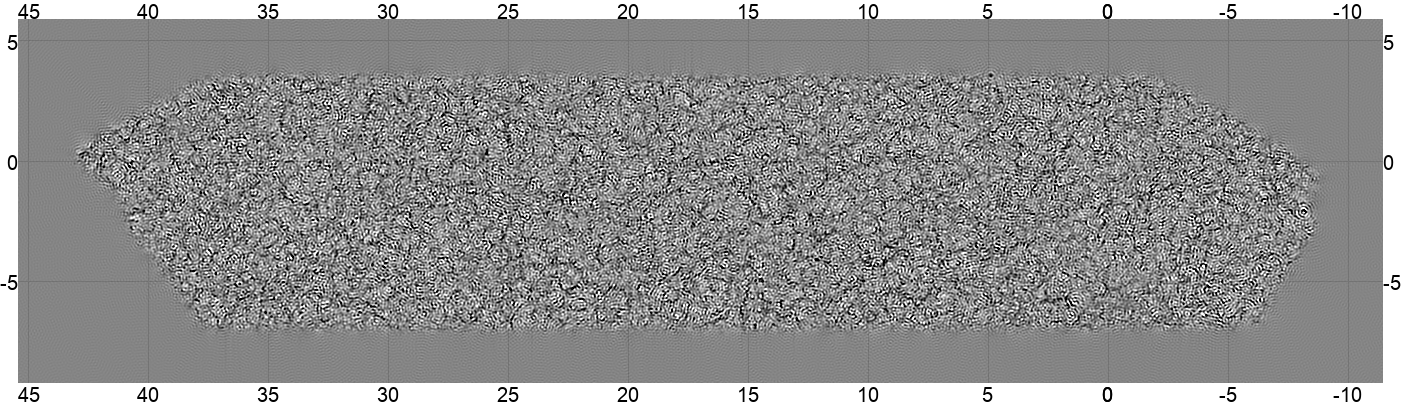

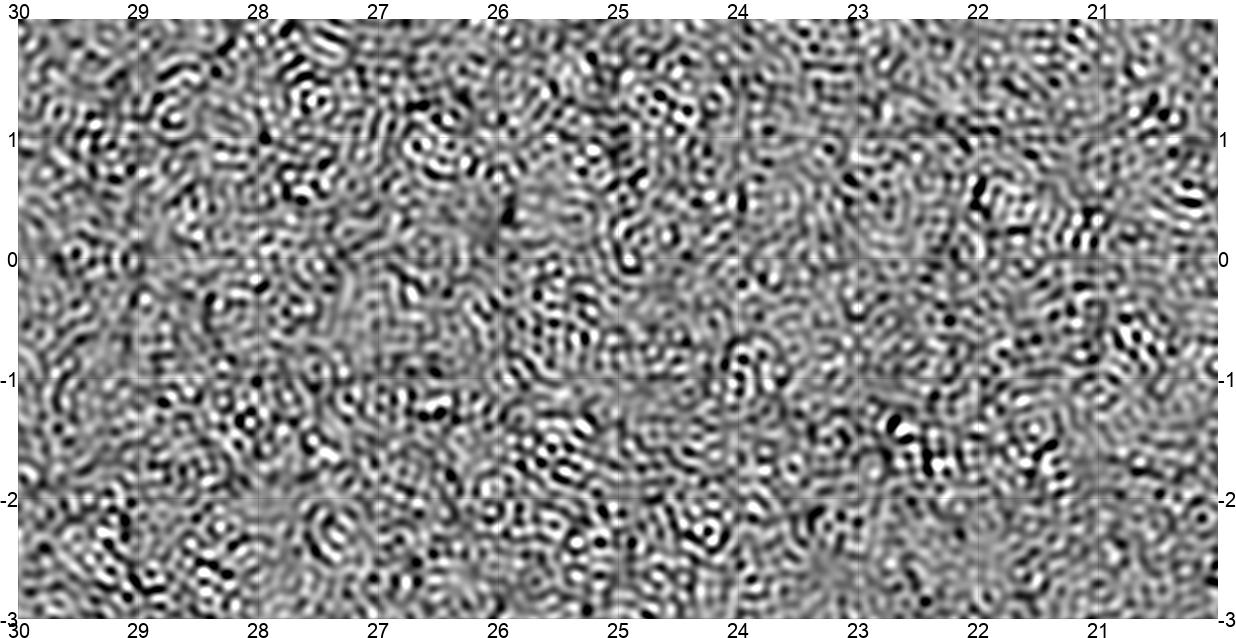

In [3]:
# Plot the entire map and thenn a smaller slice of it using the "sub" key 
eshow(lensing, **{"downgrade": 5, "ticks": 5, "color": 'gray'})
eshow(lensing,**{"sub":"-3 :2 ,30:20", "color": 'gray'} )

## Cross correlate with a galaxy over density map

These lensing maps can be cross correlated with other maps either directly in Pixell or by reprojecting to HEALPix.  For this demonstration we will cross correlate the lensing map with a galaxy overdensity map.  Since HEALPix is based on equal area pixels it is somewhat easier to build a density map in HEALPix.  In order to then cross correlate with the lensing map we will project the above CAR map to HEALPix as described in the Section 3 notebook. 

Once we've reprojected the map we can build a galaxy overdensity map using the definition
\begin{align}
g(\hat{n}) = \frac{n(\hat{n}) - \tilde n}{\tilde n} 
 \tag{1}
\end{align}

Where $n(\hat{n})$ is the number of galaxies in that pixel.

This process is based on a notebook produced by Mathew Madhavacheril that is available [here](https://github.com/ACTCollaboration/Season2LensingMaps/blob/master/LensingXCorr.ipynb)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


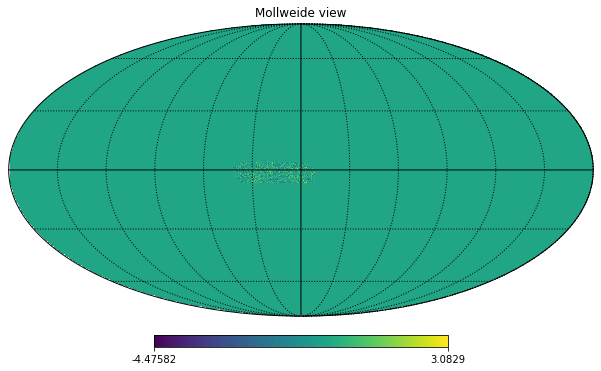

In [4]:
# Project the lensing map to HEALPix
lensing_hp =  reproject.healpix_from_enmap(lensing, lmax = 6000, nside = 624)
hp.mollview(lensing_hp)
hp.graticule()

## Make the overdensity map

To begin with we will read in a catalog of galaxies.  This can be found [here](https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz) from SDSS' BOSS catalog of CMASS galaxies.  

In [5]:
from astropy.io import fits
from astropy import units as u
redmap_hdu = fits.open(path + "galaxy_DR12v5_CMASSLOWZTOT_South.fits")

class galaxy_catalog:
    def __init__(self, catalog):
        self.RA  = catalog[1].data['RA'] *u.deg
        self.DEC = catalog[1].data['DEC']*u.deg
        
redmap = galaxy_catalog(redmap_hdu)

### Generating an over density map using the catalog

Now that we have the catalog we can generate an over density map by first creating an `ndmap` with the same shape and size as the lensed map, but filled with zeros.  From there we can find the pixel location of each galaxy and add the galaxies to our empty map.  We then finish by subtracting the mean from each pixel and dividing by the mean as indicated by equation 1 above.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


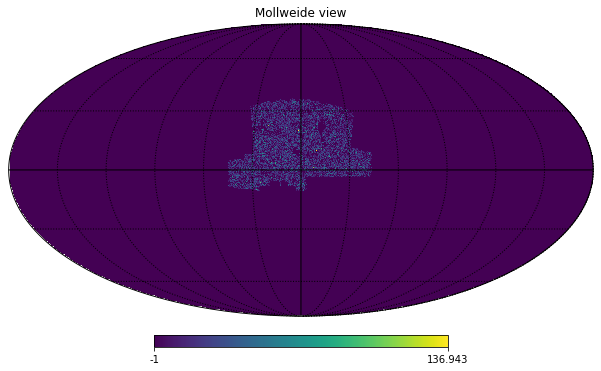

In [6]:
nside = 624
class catMapper():
    def __init__(self,ras_deg,decs_deg, weights = None):
            self.nside = nside
            self.shape = hp.nside2npix(nside)
            self.pixs = hp.ang2pix(nside,ras_deg,decs_deg,lonlat=True)
            self.counts = self.get_map(weights=weights)

    def get_map(self,weights=None):
        return np.histogram(self.pixs,bins=self.shape,weights=weights,range=[0,self.shape],density=False)[0].astype(np.float32)

mean = catMapper(redmap.RA.value, redmap.DEC.value).get_map().mean()
galaxyMap = (catMapper(redmap.RA.value, redmap.DEC.value).get_map()- mean)/mean

hp.mollview(galaxyMap)
hp.graticule()

### Cross correlate

Now that since we are able to visualize the lensed map as well as the galaxy map we can cross correlate them.  The cross correlation process in Pixell is discussed in greater detail in Notebooks 7 and 8, so for a more in-depth understanding of the process, we encourage you to consult those notebooks. For now we note that this is done by apodizing the maps and then using a Fourier transform approach to calculate the cross spectrum between the two maps. 

We also need to take into account the mask that has been applied to the maps.  Ordinarily one can correct for the effects of masking using
$$C_L -> \frac{C_L}{\langle W\rangle} $$
However the lensing maps already have a window applied to them before the reconstruction takes place and so to correctly account for the window we need to remove the CMB window correction ($W_c$) and then correct for both the CMB and Lensing windows.  We remove the CMB window at the map level by multiplying by $\langle W_c^2\rangle$.  Once that is done we cross correlate the two and then we account for the windows in the power spectrum as follows:

Option 1: If we are only applying a window to the galaxy map, as we'll do here, we can use:
$$ C_L -> \frac{1}{\langle W_c^2 W_L\rangle} C_L$$
Option 2: If you would like to apply a mask to both maps you would instead use the relation:
$$ C_L -> \frac{1}{\langle W_c^2 W_L^2\rangle} C_L$$

This means we need to use the lensing map window which is provided as part of the release. In the following section we will load the lensing map window.  We will then find the $\langle W_c^2\rangle$. From there we apply a new window ($W_L$) to the maps and calculate $\langle W_c^2 W_L\rangle$.

In [7]:
# Read in the lensing map window and convert it to HEALPix form
mask = enmap.read_map(path + "act_dr4.01_s14s15_D56_lensing_mask.fits")
W_c = reproject.healpix_from_enmap(mask, lmax = 6000, nside = nside)

# Calculate the mean of the window squared
W_c_mean = np.mean(W_c**2)

# Account for the window in the lensing map
lensing_hp = lensing_hp*W_c_mean

# Apply a new window to the maps by trimming the mask to a smaller size and then tapering it
# We then convert it to HEALPix format.

# Trim Mask
box = np.array([[-5,35],[2,0]])*utils.degree
mask_new = mask.submap(box)

# Define taper using enmap.apod 
apod_pix = 100 
taper    = enmap.apod(mask_new*0+1,apod_pix)
W_L = reproject.healpix_from_enmap(taper, lmax = 6000, nside = nside)

# Calculate the new window correction
W_c_W_L_mean = np.mean(W_c**2*W_L)

# Combine our two window corrections factors
w2 = W_c_W_L_mean

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### Cross Correlate the maps

Now that we have both the correct masks applied and the mask correction factor we can begin to cross correlate the two maps.  Since we have two HEALPix maps we can follow the usual cross correlation procedures and use anafast to get $C_\ell$.  This is actually slightly different to the method using in [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf).  Those results are based on Fourier transforms in Pixell, however, we choose to present a Healpix based example so that users who are more familiar with Healpix can easily follow our approach.

In [8]:
# Use anafast to generate cls
# Note we multiply both maps by the window we established above and then multiply by the "win" factor
# to correct for this new window.

cl  = hp.anafast(galaxyMap*W_L, lensing_hp)/w2
ell = np.arange(len(cl))

# Bin the resulting spectra as well as the ell values
bins      = np.linspace(50, 1500, 15)
digitized = np.digitize(ell, bins)
cl_binned  = [cl[digitized == i].mean() for i in range(1, len(bins))]
ell_binned = [ell[digitized == i].mean() for i in range(1, len(bins))]

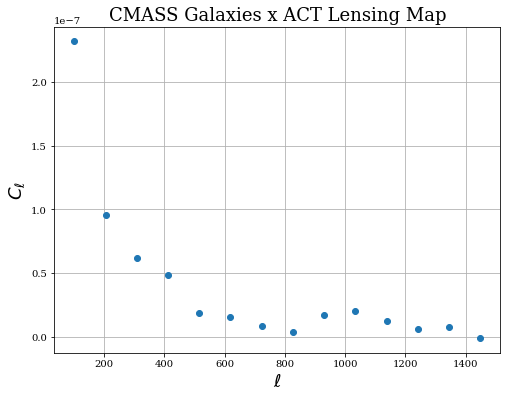

In [9]:
# Now plot the quick powerspectrum we just made
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.plot(ell_binned,cl_binned,marker="o",ls="none")
plt.xlabel('$\\ell$', fontsize = 18)
plt.ylabel('$C_{\\ell}$', fontsize = 18)
plt.title("CMASS Galaxies x ACT Lensing Map", fontsize = 18)
plt.grid(True)
plt.show()

We definitely see a signal here that tapers off and approaches zero for higher $\ell$ values but is above zero for low $\ell$, which is exactly what we expect to see.  We notice some fluctuations and of course we recognize that this quick cross correlation has only been done for D56 instead of for D56 and BN as is done in [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf).

# Continue to next Section

[Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al (2019)](https://arxiv.org/abs/1911.05717)